<img src="img/mvp_art.png" width=200 height=200 />

# CMSC320 Final Project Prototype
## Predicting the Most Valuable Player
---

In [11]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import selenium.webdriver as webdriver
import contextlib2
import unidecode as uni
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style="darkgrid")

## Finding MVP Candidates
---

In [3]:
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)),
                           level=i)
    return df
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: "".join(x))
    return df

In [4]:
votes = {}
for i in range(0,19):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(i+2001) + '.html')[0]
    data = rename_unnamed(data)
    data = collapse_columns(data)
    data = data.loc[:4, ['Rank', 'Player', 'Tm', 'VotingShare']]
    votes[i+2001] = data

## MVP Candidate Database Builder
---

    # subprocess.call(['rm','-rf','MVP'])
    # subprocess.call(['mkdir','MVP'])
    for year in votes:
        for name in votes[year]['Player']:
            if not (os.path.isdir('MVP/' + str(year) + '/' + name)):
                if not name in (['Isaiah Thomas', 'Anthony Davis']):
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '01'
                else:
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '02'

                @contextlib2.contextmanager
                def quitting(thing):
                    yield thing
                    thing.quit()
                with quitting(webdriver.Firefox()) as driver:
                    link = 'https://www.basketball-reference.com/players/' + link + '.html' 
                    driver.get(link)
                    content = driver.page_source
                    with open('/tmp/out.html', 'wb') as f:
                        f.write(content.encode('utf-8'))
                    data = pd.read_html(content)

                path1 = 'MVP/' + str(year)
                path2 = 'MVP/' + str(year) + '/' + name
                subprocess.call(['mkdir', path1])
                subprocess.call(['mkdir', path2])

                pergame = data[18]
                pergame.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                if pergame['3P%'].isnull().any():
                    pergame.drop(columns='3P%',inplace=True)
                pergame.dropna(inplace=True)
                pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
                pergame['Age'] = pergame['Age'].astype(int)
                pergame['G'] = pergame['G'].astype(int)
                pergame['GS'] =pergame['GS'].astype(int)
                pergame = pergame[pergame['Season'] == year]
                pergame.reset_index(inplace=True,drop=True)
                pergame = pergame.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                        'FG%', '3P%', 'eFG%', 'FT%']]
                # pergame.to_csv(path2 + '/Table_PerGame.csv')
                pergame.to_csv(path2 + '/PerGame.csv')

                advanced = data[22]
                if 'Unnamed: 19' in advanced.columns:
                    advanced.drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
                advanced.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                advanced.dropna(inplace=True)
                advanced['Season'] = [int(str(x).split('-')[0])+1 for x in advanced['Season']]
                advanced['Age'] = advanced['Age'].astype(int)
                advanced['G'] = advanced['G'].astype(int)
                advanced = advanced[advanced['Season'] == year]
                advanced.reset_index(inplace=True,drop=True)
                advanced = advanced.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'TRB%', 
                                            'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 
                                            'OBPM', 'DBPM', 'BPM', 'VORP']]
                # advanced.to_csv(path2 + '/Table_Advanced.csv')
                advanced.to_csv(path2 + '/Advanced.csv')
        i = 0
        for team in votes[year]['Tm']:
            if team == 'NOP':
                team = 'NOH'
            name = votes[year]['Player'][i]
    #         if not (os.path.isfile('MVP/' + str(year) + '/' + name + '/Team.csv')):
            table = pd.read_html('https://www.basketball-reference.com/teams/' + team + 
                                 '/stats_per_game_totals.html')[0]
            table.replace('Season', '0000-00', inplace=True)
            table['Season'] = [int(str(x).split('-')[0])+1 for x in table['Season']]
            table = table[table['Season'] == year]
            table['Win_Pct'] = table['W'].astype(int)/table['G'].astype(int)
            table = table.loc[:, ['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                  'FG%', '3P%', 'FT%']]
            table.to_csv('MVP/' + str(year) + '/' + name + '/Team.csv')
            i += 1

In [105]:
per_game = {}
advanced = {}
team_data = {}
for year in votes:
    i = 0
    for name in votes[year]['Player']:
        path = 'MVP/' + str(year) + '/' + name
        per_game[(name,year)] = pd.read_csv(path + '/' + 'Table_PerGame.csv').drop(columns='Unnamed: 0')
        per_game[(name,year)]['Name'] = name
        per_game[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
#         per_game[(name,year)]['Ranking'] = (i%5)+1
        advanced[(name,year)] = pd.read_csv(path + '/' + 'Table_Advanced.csv').drop(columns='Unnamed: 0')
        advanced[(name,year)]['Name'] = name
        advanced[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
#         advanced[(name,year)]['Ranking'] = (i%5)+1
        i += 1
    i = 0
    for team in votes[year]['Tm']:
        name = votes[year]['Player'][i]
        team_data[(name,year)] = pd.read_csv('MVP/' + str(year) + '/' + name + 
                                             '/Team.csv').drop(columns='Unnamed: 0')
        team_data[(name,year)]['Name'] = name
        team_data[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
#         team_data[(name,year)]['Ranking'] = (i%5)+1
        i += 1

In [170]:
# Per Game Statistics
pg = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        pg = pg.append(per_game[(name,year)], ignore_index=True)
# Advanced Statistics
adv = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        adv = adv.append(advanced[(name,year)], ignore_index=True)
# Team Statistics
tm = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        tm = tm.append(team_data[(name,year)], ignore_index=True)
ctb = pg.copy(deep=True)[['Season', 'Tm', 'PTS','TRB','AST','STL','BLK', 'TOV', 'FG%', '3P%', 'FT%',
                                    'Name', 'VotingShare']]
ctb['PTS'] /= tm['PTS']
ctb['TRB'] /= tm['TRB']
ctb['AST'] /= tm['AST']
ctb['STL'] /= tm['STL']
ctb['BLK'] /= tm['BLK']
ctb['TOV'] /= tm['TOV']
ctb['FG%'] /= tm['FG%']
ctb['3P%'] /= tm['3P%']
ctb['FT%'] /= tm['FT%']

In [107]:
pg.replace(np.nan, 0, inplace=True)
pg['Candidate'] = pg['Name'] + ', ' + pg['Season'].astype(str)
pg.head(10)

,Season,Tm,Pos,G,MP,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare,Candidate
0,2001,PHI,SG,71,42.0,31.1,3.8,4.6,2.5,0.3,3.3,0.420,0.320,0.447,0.814,Allen Iverson,0.904,"Allen Iverson, 2001"
1,2001,SAS,PF,82,38.7,22.2,12.2,3.0,0.9,2.3,3.0,0.499,0.259,0.502,0.618,Tim Duncan,0.569,"Tim Duncan, 2001"
2,2001,LAL,C,74,39.5,28.7,12.7,3.7,0.6,2.8,2.9,0.572,0.000,0.572,0.513,Shaquille O'Neal,0.466,"Shaquille O'Neal, 2001"
3,2001,SAC,PF,70,40.5,27.1,11.1,4.2,1.3,1.7,2.8,0.481,0.071,0.481,0.703,Chris Webber,0.420,"Chris Webber, 2001"
4,2001,MIN,PF,81,39.5,22.0,11.4,5.0,1.4,1.8,2.8,0.477,0.288,0.484,0.764,Kevin Garnett,0.122,"Kevin Garnett, 2001"
5,2002,SAS,PF,82,40.6,25.5,12.7,3.7,0.7,2.5,3.2,0.508,0.100,0.508,0.799,Tim Duncan,0.757,"Tim Duncan, 2002"
6,2002,NJN,PG,82,37.3,14.7,7.3,9.9,2.1,0.2,3.5,0.391,0.321,0.442,0.814,Jason Kidd,0.712,"Jason Kidd, 2002"
7,2002,LAL,C,67,36.1,27.2,10.7,3.0,0.6,2.0,2.6,0.579,0.000,0.579,0.555,Shaquille O'Neal,0.552,"Shaquille O'Neal, 2002"
8,2002,ORL,SG,76,38.3,25.6,7.9,5.3,1.6,1.0,2.5,0.451,0.364,0.483,0.748,Tracy McGrady,0.310,"Tracy McGrady, 2002"
9,2002,LAL,SG,80,38.3,25.2,5.5,5.5,1.5,0.4,2.8,0.469,0.250,0.479,0.829,Kobe Bryant,0.078,"Kobe Bryant, 2002"


In [108]:
adv['Candidate'] = adv['Name'] + ', ' + adv['Season'].astype(str)
adv.head(10)

,Season,Tm,Pos,G,MP,PER,TS%,3PAr,FTr,TRB%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Name,VotingShare,Candidate
0,2001,PHI,SG,71,2979.0,24.0,0.518,0.169,0.397,5.2,...,4.5,11.8,0.190,5.0,-0.1,4.8,5.1,Allen Iverson,0.904,"Allen Iverson, 2001"
1,2001,SAS,PF,82,3174.0,23.8,0.536,0.019,0.471,17.8,...,7.1,13.2,0.200,1.8,3.6,5.4,5.9,Tim Duncan,0.569,"Tim Duncan, 2001"
2,2001,LAL,C,74,2924.0,30.2,0.574,0.001,0.684,18.1,...,3.9,14.9,0.245,5.7,1.6,7.3,6.8,Shaquille O'Neal,0.466,"Shaquille O'Neal, 2001"
3,2001,SAC,PF,70,2836.0,24.7,0.516,0.017,0.282,14.8,...,5.2,11.0,0.186,2.6,2.4,4.9,4.9,Chris Webber,0.420,"Chris Webber, 2001"
4,2001,MIN,PF,81,3202.0,23.9,0.531,0.045,0.317,16.4,...,4.8,11.8,0.176,3.0,2.7,5.7,6.2,Kevin Garnett,0.122,"Kevin Garnett, 2001"
5,2002,SAS,PF,82,3329.0,27.0,0.576,0.007,0.466,18.0,...,7.1,17.8,0.257,3.9,3.8,7.6,8.1,Tim Duncan,0.757,"Tim Duncan, 2002"
6,2002,NJN,PG,82,3056.0,19.1,0.484,0.320,0.217,10.9,...,5.8,8.9,0.140,2.8,2.2,5.1,5.4,Jason Kidd,0.712,"Jason Kidd, 2002"
7,2002,LAL,C,67,2422.0,29.7,0.590,0.001,0.583,16.3,...,4.0,13.2,0.262,5.5,1.5,7.0,5.5,Shaquille O'Neal,0.552,"Shaquille O'Neal, 2002"
8,2002,ORL,SG,76,2912.0,25.1,0.532,0.178,0.350,11.5,...,3.4,11.5,0.189,5.2,0.8,6.0,5.9,Tracy McGrady,0.310,"Tracy McGrady, 2002"
9,2002,LAL,SG,80,3063.0,23.2,0.544,0.083,0.369,7.9,...,3.8,12.7,0.199,4.4,0.1,4.4,5.0,Kobe Bryant,0.078,"Kobe Bryant, 2002"


In [109]:
tm['Candidate'] = tm['Name'] + ', ' + tm['Season'].astype(str)
tm.head()

,Season,Tm,W,L,Win_Pct,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,Candidate
0,2001,PHI,56,26,0.682927,94.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904,"Allen Iverson, 2001"
1,2001,SAS,58,24,0.707317,96.2,44.1,21.7,6.9,7.0,14.0,0.461,0.407,0.715,Tim Duncan,0.569,"Tim Duncan, 2001"
2,2001,LAL,56,26,0.682927,100.6,44.7,23.0,6.9,6.0,14.4,0.465,0.344,0.683,Shaquille O'Neal,0.466,"Shaquille O'Neal, 2001"
3,2001,SAC,55,27,0.670732,101.7,45.0,22.6,9.7,5.3,14.9,0.449,0.354,0.771,Chris Webber,0.420,"Chris Webber, 2001"
4,2001,MIN,47,35,0.573171,97.3,42.3,25.4,8.3,5.6,13.9,0.458,0.357,0.785,Kevin Garnett,0.122,"Kevin Garnett, 2001"


In [171]:
ctb.replace(np.nan, 0, inplace=True)
ctb['Candidate'] = ctb['Name'] + ', ' + ctb['Season'].astype(str)
ctb.head(10)

,Season,Tm,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,Candidate
0,2001,PHI,0.328405,0.084821,0.223301,0.297619,0.060000,0.208861,0.939597,0.981595,1.092617,Allen Iverson,0.904,"Allen Iverson, 2001"
1,2001,SAS,0.230769,0.276644,0.138249,0.130435,0.328571,0.214286,1.082430,0.636364,0.864336,Tim Duncan,0.569,"Tim Duncan, 2001"
2,2001,LAL,0.285288,0.284116,0.160870,0.086957,0.466667,0.201389,1.230108,0.000000,0.751098,Shaquille O'Neal,0.466,"Shaquille O'Neal, 2001"
3,2001,SAC,0.266470,0.246667,0.185841,0.134021,0.320755,0.187919,1.071269,0.200565,0.911803,Chris Webber,0.420,"Chris Webber, 2001"
4,2001,MIN,0.226105,0.269504,0.196850,0.168675,0.321429,0.201439,1.041485,0.806723,0.973248,Kevin Garnett,0.122,"Kevin Garnett, 2001"
5,2002,SAS,0.263702,0.299528,0.185000,0.092105,0.384615,0.222222,1.109170,0.276243,1.076819,Tim Duncan,0.757,"Tim Duncan, 2002"
6,2002,NJN,0.152807,0.168591,0.407407,0.241379,0.033333,0.241379,0.876682,0.949704,1.107483,Jason Kidd,0.712,"Jason Kidd, 2002"
7,2002,LAL,0.268509,0.241535,0.130435,0.078947,0.344828,0.204724,1.255965,0.000000,0.793991,Shaquille O'Neal,0.552,"Shaquille O'Neal, 2002"
8,2002,ORL,0.254726,0.191748,0.240909,0.197531,0.212766,0.183824,1.006696,0.975871,0.992042,Tracy McGrady,0.310,"Tracy McGrady, 2002"
9,2002,LAL,0.248766,0.124153,0.239130,0.197368,0.068966,0.220472,1.017354,0.706215,1.185980,Kobe Bryant,0.078,"Kobe Bryant, 2002"


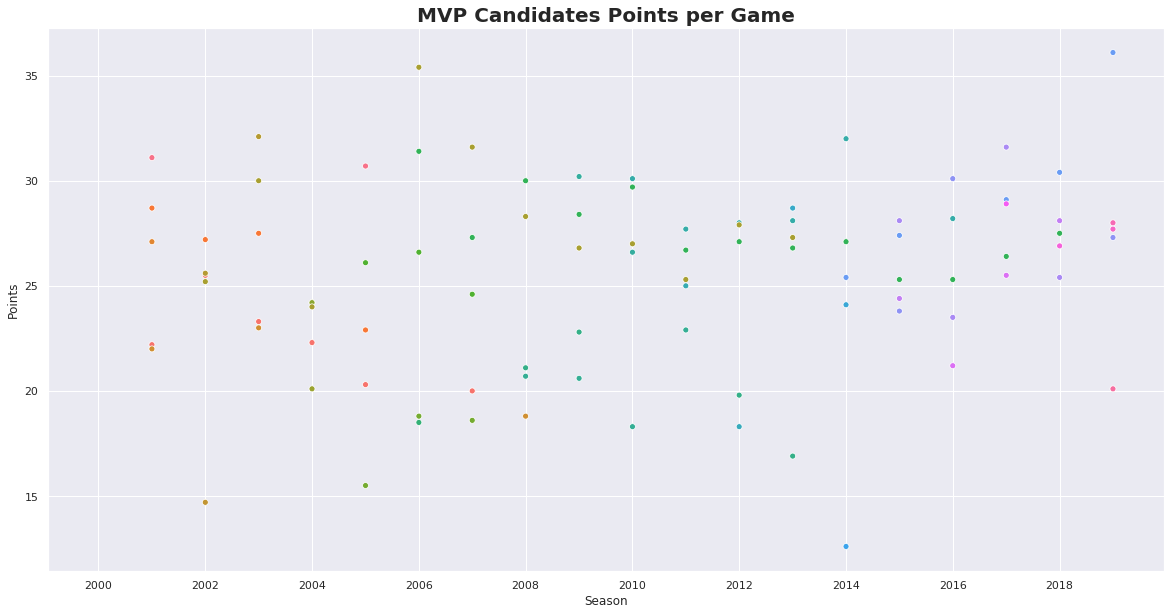

In [48]:
pts = pg.loc[:, ['Name', 'Season', 'PTS']]
pts['Season'] = [pd.to_datetime(x, format='%Y') for x in pts['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='PTS',hue='Name',data=pts,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Points per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Points')
plt.show()

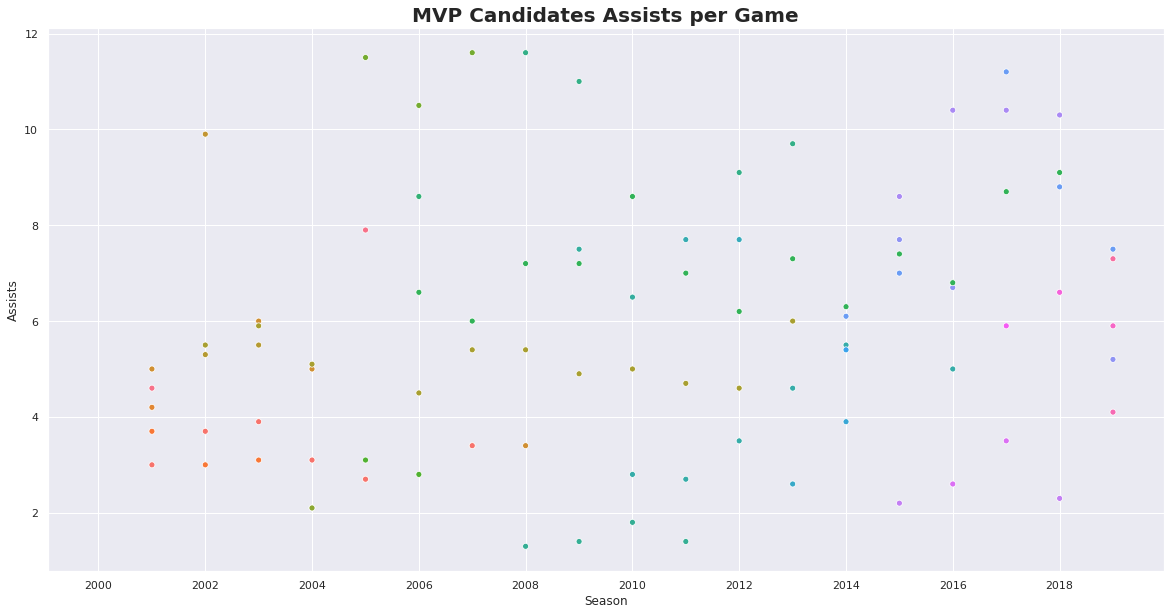

In [49]:
ast = pg.loc[:, ['Name', 'Season', 'AST']]
ast['Season'] = [pd.to_datetime(x, format='%Y') for x in ast['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='AST',hue='Name',data=ast,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Assists per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Assists')
plt.show()

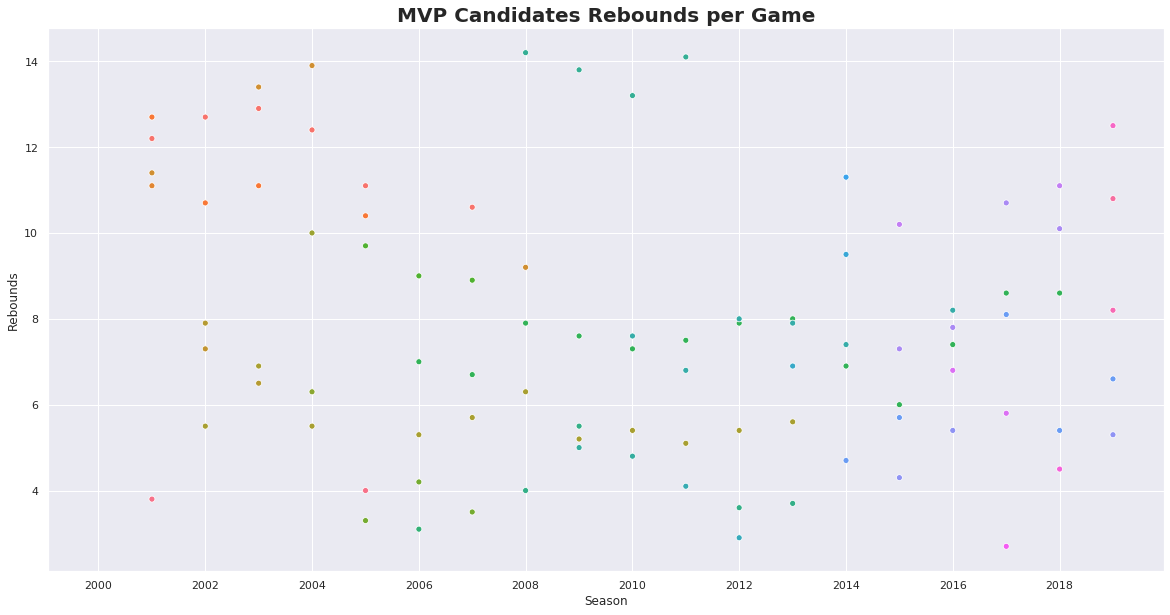

In [50]:
reb = pg.loc[:, ['Name', 'Season', 'TRB']]
reb['Season'] = [pd.to_datetime(x, format='%Y') for x in reb['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='TRB',hue='Name',data=reb,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Rebounds per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Rebounds')
plt.show()

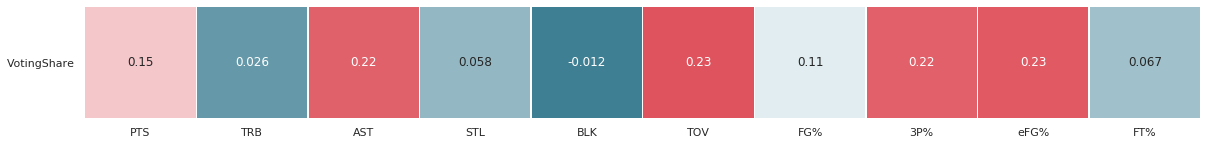

In [174]:
cmap = sns.diverging_palette(220,10, as_cmap=True)

corr = pg.corr()[['PTS','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%']]
corr = corr.take([len(pg.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.25)
plt.yticks(rotation=0)
plt.show()

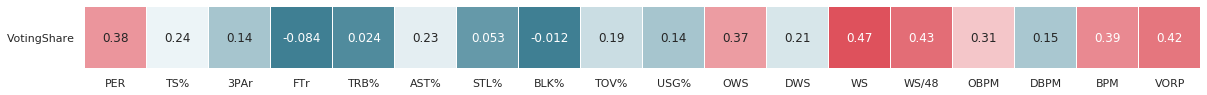

In [152]:
corr = adv.corr()[['PER','TS%','3PAr','FTr','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']]
corr = corr.take([len(adv.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.5)
plt.yticks(rotation=0)
plt.show()

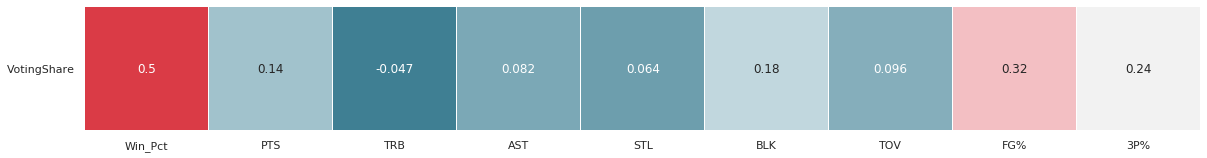

In [158]:
corr = tm.corr()[['Win_Pct','PTS','TRB','AST','STL','BLK','TOV','FG%','3P%']]
corr = corr.take([len(tm.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.5)
plt.yticks(rotation=0)
plt.show()

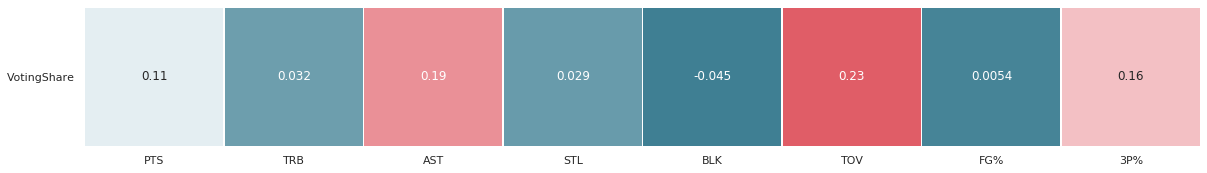

In [173]:
corr = ctb.corr()[['PTS','TRB','AST','STL','BLK','TOV','FG%','3P%']]
corr = corr.take([len(ctb.corr().columns)-1])
plt.figure(figsize=(20,10))
ax = plt.gca()
sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.25)
plt.yticks(rotation=0)
plt.show()